In [ ]:
### the first few cells are what we do to mount to google drive and retrieve the VGG data we use for clustering. The actual clustering starts below

In [ ]:
import json
import os
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
os.chdir("drive/My Drive/ML final project/openmic-2018")
!ls "/content/drive/My Drive/ML final project/openmic-2018"

acknowledgement.md  license-cc-by.txt			   openmic-2018.npz
audio		    openmic-2018-aggregated-labels.csv	   partitions
checksums	    openmic-2018-individual-responses.csv  vggish
class-map.json	    openmic-2018-metadata.csv


In [ ]:
metadata = pd.read_csv("openmic-2018-metadata.csv")
# print(metadata)
# print(np.shape(metadata))
# #print(type(metadata))

In [ ]:
# Quick note on the terms:
# .json: VGGish features as JSON objects, in a directory format like 'vggish/{0:3}/{0}.json'.format(sample_key)
# .ogg: 10 second snippets of audio, in a directory format like 'audio/{0:3}/{0}.ogg'.format(sample_key)
# .npz: A Python-friendly NPZ file of features and labels, 'openmic-2018.npz'
# VGGish: 


# Now we need to read in .json file for each track and transform them into
# spectrograms for latter input into the neural network
openmic = np.load('openmic-2018.npz', allow_pickle=True)
# Use allow_pickle = True so later the sample_key could be properly loaded


# X: (20000 by 10 by 128) array of VGGish features
#     First index (0..19999) corresponds to the sample key
#     Second index (0..9) corresponds to the time within the clip (each time slice is 960 ms long)
#     Third index (0..127) corresponds to the VGGish features at each point in the 10sec clip
#     Example X[40, 8] is the 128-dimensional feature vector for the 9th time slice in the 41st example

X = openmic['X']

# Y_true: 20000 20 array of true* label probabilities
#      First index corresponds to sample key, as above
#      Second index corresponds to the label class (accordion, ..., voice)
#      Example: Y[40, 4] indicates the confidence that example #41 contains the 5th instrument

Y_true = openmic['Y_true']


# Y_mask: 20000 * 20 binary mask values
#    First index corresponds to sample key
#    Second index corresponds to the label class
#    Example: Y[40, 4] indicates whether or not we have observations for the 5th instrument for example #41

Y_mask = openmic['Y_mask']

# sample_key: 20000 array of sample key strings
#     Example: sample_key[40] is the sample key for example #4

sample_key = openmic['sample_key']

# Import the class map for convenience
f = open('class-map.json')
class_map = json.load(f)
f.close()

In [ ]:
# these are the songs that correspond to each sample X[i]
metadata[["track_title", "album_title", "artist_name"]]

,track_title,album_title,artist_name
0,Yosemite,Niris,Nicky Cook
1,Father's Day,mp3,Abominog
2,CandyAss,Every Man For Himself,Alec K. Redfearn & the Eyesores
3,Ohio,Every Man For Himself,Alec K. Redfearn & the Eyesores
4,Wire Up,Amoebiasis,Amoebic Ensemble
...,...,...,...
19995,Cast Away,Return,Alex Mason
19996,Attraction,Return,Alex Mason/The Minor Emotion
19997,Kolka,"Live at WFMU with Scott Williams, 3/27/2017",AWOTT
19998,Raman Abhishek,"Live at WFMU with Scott Williams, 3/27/2017",AWOTT


In [ ]:
# flatten X
flatDim = X.shape[1] * X.shape[2]
numSamples = X.shape[0]
X_flat = X.reshape(numSamples, flatDim)

In [ ]:
# the number of features in X_flat is very high, so we would benefit from performing PCA to reduce the dimensionality of our samples
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_flat)

PCA()

In [ ]:
# here we can see that if we keep the only the components that make up at least 1% of the variance, we can reduce our number of features to 182!
print((pca.explained_variance_ratio_ > .001).sum())

182


In [ ]:
# using a mask trick, we can also see that these 182 components make up ~70% of the overall variance, and so using a PCA with 182 components would be a good approach
mask = pca.explained_variance_ratio_ > .001
modified = mask * pca.explained_variance_ratio_
print(modified.sum())

0.6966598560550833


In [ ]:
pca2 = PCA(n_components=182)
X_reduced = pca2.fit_transform(X_flat)

In [ ]:
# X_reduced is our new feature matrix!
print(X_flat.shape)
print(X_reduced.shape)

(20000, 1280)
(20000, 182)


In [ ]:
# normalize the data

from sklearn import preprocessing

scaler_train = preprocessing.StandardScaler().fit(X_reduced)
X_reduced_scaled = scaler_train.transform(X_reduced)

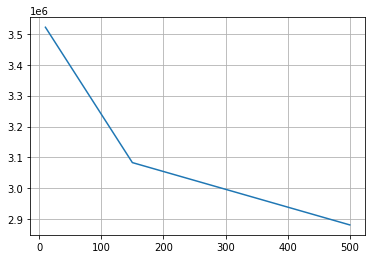

In [ ]:
# now we can cluster the data
# we don't have labels so there isn't necessarily a great reason to get a test set, so we will cluster all of the data

# we tried spectral clustering, but there was not enough RAM on this colab session to run it

# method 1: k-means
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

inertias = []
# test = [5, 10, 20, 30, 50, 70, 90, 120, 140, 160, 200, 240, 280, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500]
test = [10, 150, 500]
##### test is shortened so the cell can run quickly
for k in test:
    kmeans = KMeans(n_clusters=k).fit(X_reduced_scaled)
    inertias.append(kmeans.inertia_)

# plot the elbow curve so we can find the optimal number of clusters (about 150 - 200)
plt.plot(test, inertias)
plt.grid(True)



In [ ]:
# the above cell takes a while to run, but the elbow was around 150 clusters
from sklearn.cluster import KMeans
labels = KMeans(n_clusters=150).fit_predict(X_reduced_scaled)


In [ ]:
print(labels)
groups = dict()
for i in range(len(labels)):
  curLabel = labels[i]
  if curLabel in groups:
    groups[curLabel].append(i)
  else:
    groups[curLabel] = [i]

[135 148  41 ... 101 121  73]


In [ ]:
### groups now indicates which song is in which cluster. Because we have the metadata info from before, metadata[i] gives us the name of a song and its corresponding album/artist, so we
### can evaluate the results (which was one of our uncompleted deliverables)
print(groups)

### using this, we see that each cluster had a lot of songs in them, and so the distribution is not heavily biased towards just a couple of clusters
dens = dict()
for key in groups.keys():
  dens[key] = len(groups[key])
print(dens)
print(len(groups.keys()))

{135: [0, 26, 120, 168, 286, 372, 384, 595, 920, 946, 1723, 1734, 1888, 1971, 2005, 2284, 2320, 2474, 2487, 2882, 3081, 3115, 3583, 4206, 4265, 4276, 4307, 4812, 4986, 5121, 5555, 5557, 5688, 5705, 5925, 6031, 6291, 6303, 6314, 6358, 6468, 6470, 6653, 6706, 6761, 6824, 7097, 7399, 7540, 7545, 7552, 7611, 7617, 7689, 7804, 7805, 7824, 7843, 8038, 8248, 8292, 8509, 8657, 8909, 8946, 8973, 9055, 9351, 9411, 9658, 9659, 9726, 9787, 10078, 10129, 10279, 10333, 10686, 11027, 11306, 11338, 11546, 11700, 12113, 12155, 12166, 12229, 12382, 12469, 12489, 12579, 13131, 13151, 13238, 13805, 13815, 14333, 14866, 15044, 15057, 15061, 15106, 15237, 15345, 15500, 15636, 15812, 15830, 15999, 16129, 16134, 16148, 16222, 16399, 16526, 16654, 16758, 16811, 16812, 16833, 17120, 17198, 17200, 17205, 17232, 17284, 17578, 17664, 18075, 18096, 18120, 18213, 18294, 18316, 18606, 18710, 18763, 19176, 19222, 19240, 19289, 19310, 19328, 19331, 19398, 19422, 19427, 19645, 19676, 19775, 19914, 19930, 19986], 148: [1

In [ ]:
# these are the songs that correspond to each sample X[i]
short = metadata[["track_title", "album_title", "artist_name", "track_date_created", "track_genres"]]

In [ ]:
### for example, we can look at 2 songs that got put in the same cluster:
print(groups[148])

[1, 27, 28, 42, 43, 53, 97, 103, 166, 735, 1185, 1541, 2603, 2611, 2901, 3478, 3501, 3642, 3655, 3677, 3729, 3732, 3849, 3859, 3908, 3975, 4005, 4068, 4134, 4438, 4504, 4507, 4559, 4579, 4910, 5009, 5010, 5245, 5279, 5303, 5376, 5379, 5390, 5398, 5418, 5421, 6272, 6435, 6490, 6531, 6532, 6533, 6878, 7130, 7142, 7523, 7815, 8401, 8407, 8529, 9355, 9976, 9981, 10023, 10286, 10660, 10909, 11069, 11381, 11511, 11613, 11829, 11838, 12068, 12096, 12204, 12207, 12222, 12324, 12327, 12406, 12732, 12899, 13270, 14574, 15143, 15309, 15573, 15736, 15856, 16137, 16482, 16502, 16528, 16740, 16828, 16995, 17383, 17513, 17515, 17770, 17827, 18233, 18422, 18683, 19487, 19503, 19583, 19609, 19623]


In [ ]:
# so song number 2155 and 2160 were in the same group. Looking at their metadata as well as listening to them, they seem similar (same genre,...)
print("song 2155: \n", short.loc[2155], "\ngenres: ", metadata["track_genres"].loc[2155])
print("\n\n\n\n")
print("song 2160: \n", short.loc[2160], "\ngenres: ", metadata["track_genres"].loc[2160])

song 2155: 
 track_title                                              Pa Las Mayores
album_title           Live at WFMU's Transpacific Sound Paradise 8/1...
artist_name                                           Gato Loco de Bajo
track_date_created                                8/26/2009 10:32:35 AM
track_genres          [{'genre_id': '4', 'genre_title': 'Jazz', 'gen...
Name: 2155, dtype: object 
genres:  [{'genre_id': '4', 'genre_title': 'Jazz', 'genre_url': 'http://freemusicarchive.org/genre/Jazz/'}]





song 2160: 
 track_title                                    Thirteen Unlucky Daisies
album_title                                    Odd Times, Uneven Dreams
artist_name                                               Claudio Nuñez
track_date_created                                8/27/2009 04:32:42 AM
track_genres          [{'genre_id': '4', 'genre_title': 'Jazz', 'gen...
Name: 2160, dtype: object 
genres:  [{'genre_id': '4', 'genre_title': 'Jazz', 'genre_url': 'http://freemusicarchiv

In [ ]:
### if we had more time, we would have come up with more strict evaluations, such as using spotify's song metrics (tempo, dancability,....) or using the genres given in the metadata